# Imports, seed e leitura (com detecção de caminho)

In [2]:
from pathlib import Path
import json, pathlib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

SEED = 42
np.random.seed(SEED)

candidates = [
    Path("../data/processed/mvi_pe_features.csv"),  # notebook -> raiz
    Path("data/processed/mvi_pe_features.csv"),     # caso rode na raiz
    Path("../../data/processed/mvi_pe_features.csv")
]
for p in candidates:
    if p.exists():
        csv_path = p
        break
else:
    raise FileNotFoundError(f"mvi_pe_features.csv não encontrado. Procurei em: {candidates}")

df = pd.read_csv(csv_path, parse_dates=["date"])
df.head()


,municipio,ano,mes,mvi,date,lag1,ma3,ma6,chg,alto_risco_mvi_next,mes_sin,mes_cos
0,ABREU E LIMA,2004,7,4,2004-07-01,2.0,5.000000,4.833333,-0.60,0,-0.500000,-8.660254e-01
1,ABREU E LIMA,2004,8,4,2004-08-01,4.0,3.666667,4.833333,1.00,0,-0.866025,-5.000000e-01
2,ABREU E LIMA,2004,9,1,2004-09-01,4.0,3.333333,4.833333,0.00,0,-1.000000,-1.836970e-16
3,ABREU E LIMA,2004,10,4,2004-10-01,1.0,3.000000,4.000000,-0.75,0,-0.866025,5.000000e-01
4,ABREU E LIMA,2004,11,1,2004-11-01,4.0,3.000000,3.333333,3.00,1,-0.500000,8.660254e-01


## Features/target e split temporal (treino ≤2022, teste ≥2023)

In [3]:
target = "alto_risco_mvi_next"
num_cols = ["lag1","ma3","ma6","chg","mes_sin","mes_cos"]
cat_cols = ["municipio"]

cutoff = pd.Timestamp("2023-01-01")
train_mask = df["date"] < cutoff
test_mask  = df["date"] >= cutoff

X_train = df.loc[train_mask, num_cols + cat_cols]
y_train = df.loc[train_mask, target].astype(int)
X_test  = df.loc[test_mask,  num_cols + cat_cols]
y_test  = df.loc[test_mask,  target].astype(int)

print("Shapes:", X_train.shape, X_test.shape)
print("Alvo treino (média=proporção de 1):", y_train.mean().round(3))
print("Alvo teste  (média=proporção de 1):", y_test.mean().round(3))


Shapes: (19467, 7) (2609, 7)
Alvo treino (média=proporção de 1): 0.448
Alvo teste  (média=proporção de 1): 0.383


## Pré-processamento

In [4]:
pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

## Função de treino/avaliação (salva matriz + mostra relatório)

In [5]:
def treina_avalia(model, nome):
    pipe = Pipeline([("pre", pre), ("clf", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1m = f1_score(y_test, pred, average="macro")

    cm = confusion_matrix(y_test, pred, labels=[0,1])
    pathlib.Path("../reports/figuras").mkdir(parents=True, exist_ok=True)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(values_format="d")
    plt.title(f"Matriz de confusão – {nome}")
    plt.savefig(f"../reports/figuras/cm_{nome.replace(' ','_').lower()}.png", bbox_inches="tight")
    plt.show()

    print(f"\n{nome} — classification_report")
    print(classification_report(y_test, pred, digits=3))
    return {"modelo": nome, "accuracy": float(acc), "f1_macro": float(f1m)}


## Rodar Baseline + LogReg + RandomForest e salvar métricas

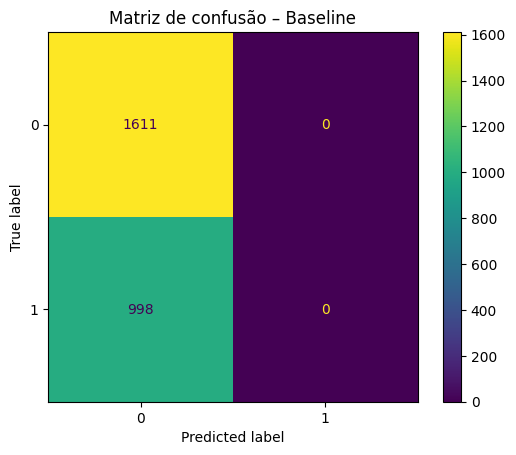


Baseline — classification_report
              precision    recall  f1-score   support

           0      0.617     1.000     0.764      1611
           1      0.000     0.000     0.000       998

    accuracy                          0.617      2609
   macro avg      0.309     0.500     0.382      2609
weighted avg      0.381     0.617     0.471      2609



c:\Users\corre\Desktop\crime-pe-entrega1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\corre\Desktop\crime-pe-entrega1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\corre\Desktop\crime-pe-entrega1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

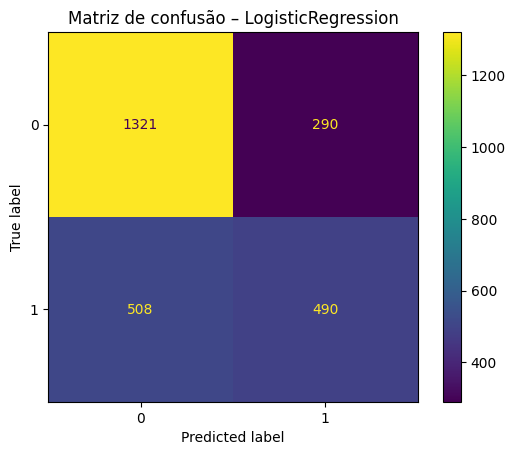


LogisticRegression — classification_report
              precision    recall  f1-score   support

           0      0.722     0.820     0.768      1611
           1      0.628     0.491     0.551       998

    accuracy                          0.694      2609
   macro avg      0.675     0.655     0.660      2609
weighted avg      0.686     0.694     0.685      2609



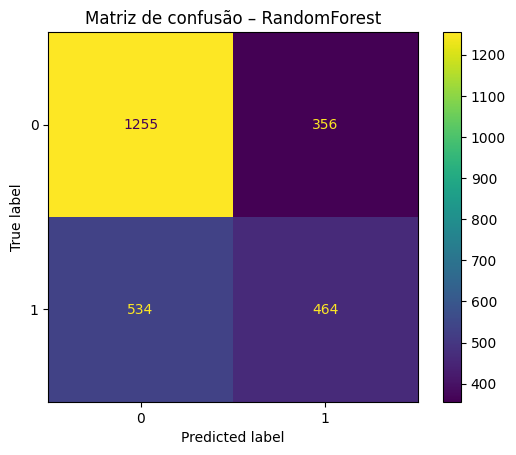


RandomForest — classification_report
              precision    recall  f1-score   support

           0      0.702     0.779     0.738      1611
           1      0.566     0.465     0.510       998

    accuracy                          0.659      2609
   macro avg      0.634     0.622     0.624      2609
weighted avg      0.650     0.659     0.651      2609



,modelo,accuracy,f1_macro
0,Baseline,0.617478,0.381754
1,LogisticRegression,0.694136,0.659602
2,RandomForest,0.658873,0.624343


Métricas salvas em ../reports/metrics.json


In [6]:
resultados = []
resultados.append(treina_avalia(DummyClassifier(strategy="most_frequent", random_state=SEED), "Baseline"))
resultados.append(treina_avalia(LogisticRegression(max_iter=400, class_weight="balanced", random_state=SEED), "LogisticRegression"))
resultados.append(treina_avalia(RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=SEED, n_jobs=-1), "RandomForest"))

display(pd.DataFrame(resultados))

pathlib.Path("../reports").mkdir(exist_ok=True)
with open("../reports/metrics.json","w") as f:
    json.dump(resultados, f, indent=2)
print("Métricas salvas em ../reports/metrics.json")


## Otimização de Threshold - Regressão Logística

Melhor threshold≈ 0.480 | F1-macro≈ 0.662


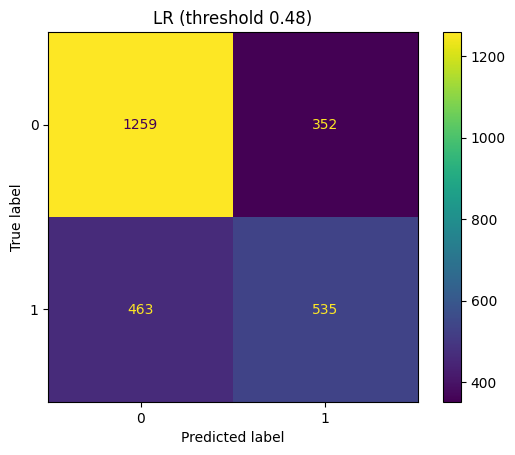

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np, matplotlib.pyplot as plt, pathlib, json

pipe_lr = Pipeline([("pre", pre),
                    ("clf", LogisticRegression(max_iter=400, class_weight="balanced", random_state=SEED))])
pipe_lr.fit(X_train, y_train)

probs = pipe_lr.predict_proba(X_test)[:, 1]
ths = np.linspace(0.2, 0.8, 61)
scores = [f1_score(y_test, (probs >= t).astype(int), average="macro") for t in ths]
best_t = ths[int(np.argmax(scores))]
best_f1 = max(scores)
print(f"Melhor threshold≈ {best_t:.3f} | F1-macro≈ {best_f1:.3f}")

pred_best = (probs >= best_t).astype(int)
cm = confusion_matrix(y_test, pred_best, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(values_format="d"); plt.title(f"LR (threshold {best_t:.2f})")
pathlib.Path("../reports/figuras").mkdir(parents=True, exist_ok=True)
plt.savefig("../reports/figuras/cm_logreg_threshold.png", bbox_inches="tight"); plt.show()

## Random Forest com RandomizedSearchCV

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
params = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [None, 8, 12, 16],
    "clf__min_samples_leaf": [1, 2, 4]
}
pipe_rf = Pipeline([("pre", pre),
                    ("clf", RandomForestClassifier(class_weight="balanced_subsample", random_state=SEED, n_jobs=-1))])
rs = RandomizedSearchCV(pipe_rf, params, n_iter=10, scoring="f1_macro", cv=3, random_state=SEED, n_jobs=-1)
rs.fit(X_train, y_train)
print("RF best:", rs.best_params_, rs.best_score_)
pred = rs.best_estimator_.predict(X_test)

RF best: {'clf__n_estimators': 600, 'clf__min_samples_leaf': 4, 'clf__max_depth': 8} 0.5329636033092123


## Salvando Métricas do Modelo Otimizado

In [ ]:
import json, pathlib
from sklearn.metrics import accuracy_score, f1_score

pred_lr_t = (probs >= best_t).astype(int)  # usa 'probs' e 'best_t' do bloco
acc_lr_t  = accuracy_score(y_test, pred_lr_t)
f1_lr_t   = f1_score(y_test, pred_lr_t, average="macro")

path = pathlib.Path("../reports/metrics.json")
with open(path) as f:
    resultados = json.load(f)

resultados.append({
    "modelo": f"LogisticRegression@{best_t:.2f}",
    "accuracy": float(acc_lr_t),
    "f1_macro": float(f1_lr_t)
})

with open(path, "w") as f:
    json.dump(resultados, f, indent=2)

print("Atualizado:", path)


Atualizado: ..\reports\metrics.json


## Salvar classification reports

In [ ]:
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pathlib

def save_report(nome, y_true, y_pred):
    p = pathlib.Path("../reports") / f"classif_report_{nome}.txt"
    with open(p, "w") as f:
        f.write(classification_report(y_true, y_pred, digits=3))
    print("salvo:", p)

# Baseline
pipe_base = Pipeline([("pre", pre), ("clf", DummyClassifier(strategy="most_frequent", random_state=SEED))])
pipe_base.fit(X_train, y_train)
pred_base = pipe_base.predict(X_test)
save_report("baseline", y_test, pred_base)

# LogisticRegression (padrão 0.50)
pipe_lr_std = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=400, class_weight="balanced", random_state=SEED))])
pipe_lr_std.fit(X_train, y_train)
pred_lr = pipe_lr_std.predict(X_test)
save_report("logreg", y_test, pred_lr)

# LogisticRegression com threshold ótimo (usa o probs e best_t já calculados)
pred_lr_t = (probs >= best_t).astype(int)
save_report(f"logreg_threshold_{best_t:.2f}", y_test, pred_lr_t)

# RandomForest (tuned)
pipe_rf_best = Pipeline([("pre", pre), ("clf", RandomForestClassifier(
    n_estimators=600, max_depth=8, min_samples_leaf=4,
    class_weight='balanced_subsample', n_jobs=-1, random_state=SEED))])
pipe_rf_best.fit(X_train, y_train)
pred_rf = pipe_rf_best.predict(X_test)
save_report("randomforest_tuned", y_test, pred_rf)


c:\Users\corre\Desktop\crime-pe-entrega1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\corre\Desktop\crime-pe-entrega1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\corre\Desktop\crime-pe-entrega1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

salvo: ..\reports\classif_report_baseline.txt
salvo: ..\reports\classif_report_logreg.txt
salvo: ..\reports\classif_report_logreg_threshold_0.48.txt
salvo: ..\reports\classif_report_randomforest_tuned.txt
